In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import  pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50, DenseNet201
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Attention, Reshape, Multiply
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from dataclasses import dataclass, asdict
import yaml
from typing import Optional, Union, List
from dacite import from_dict
import numpy as np
import math
import json
import itertools
import ast
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import random
from random import randrange
import pandas as pd
%matplotlib inline

!pip install tensorflow-addons

### checking if GPU available

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


conda create -n seaborn r python=3.6
activate seaborn
pip install --ignore-installed --upgrade seaborn

# Utilities

In [3]:
dest_dir = '/home/ubuntu/data/3classes/HAM10000_by_class/'
data_dir = '/home/ubuntu/data/HAM10000_all_images'
df = pd.read_csv('/home/ubuntu/data/bkp/HAM10000_metadata.csv')

In [4]:
mapping = {'mel': 'mel', 'bcc':'bcc', 'nv':'others', 'bkl':'others', 'akiec':'others','vasc':'others','df':'others'}

In [5]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [6]:
df["dx"].replace(mapping, inplace=True)

In [7]:
df['dx'].value_counts()

others    8388
mel       1113
bcc        514
Name: dx, dtype: int64

In [8]:
label = df['dx'].unique().tolist()
print(label)
label_images = []

['others', 'mel', 'bcc']


In [9]:
for i in label:
    print(dest_dir + str(i) + '/')
    try:
        os.mkdir(dest_dir + str(i))
    except OSError:
        pass
#     os.mkdir(dest_dir + str(i))
    sample = df[df['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + '/' + id + '.jpg'), (dest_dir + str(i) + '/' + id + '.jpg'))
    label_images = []

/home/ubuntu/data/3classes/HAM10000_by_class/others/
/home/ubuntu/data/3classes/HAM10000_by_class/mel/
/home/ubuntu/data/3classes/HAM10000_by_class/bcc/


In [10]:
rmdir /home/ubuntu/data/3classes/HAM10000_by_class/.ipynb_checkpoints/

In [11]:
'''
Split input images into train and test images based on the percentage passed as input
'''
import numpy as np
def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct):
    # Recreate testing and training directories
    if testing_data_dir.count('/') > 1:
        shutil.rmtree(testing_data_dir, ignore_errors=False)
        os.makedirs(testing_data_dir)
        print("Successfully cleaned directory " + testing_data_dir)
    else:
        print("Refusing to delete testing data directory " + testing_data_dir + " as we prevent you from doing stupid things!")

    if training_data_dir.count('/') > 1:
        shutil.rmtree(training_data_dir, ignore_errors=False)
        os.makedirs(training_data_dir)
        print("Successfully cleaned directory " + training_data_dir)
    else:
        print("Refusing to delete testing data directory " + training_data_dir + " as we prevent you from doing stupid things!")

    num_training_files = 0
    num_testing_files = 0

    for subdir, dirs, files in os.walk(all_data_dir):
        category_name = os.path.basename(subdir)

        # Don't create a subdirectory for the root directory
        print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
            continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name

        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)

        for file in files:
            input_file = os.path.join(subdir, file)
            if np.random.rand(1) < testing_data_pct:
                shutil.copy(input_file, testing_data_dir + '/' + category_name + '/' + file)
                num_testing_files += 1
            else:
                shutil.copy(input_file, training_data_dir + '/' + category_name + '/' + file)
                num_training_files += 1

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

In [12]:
all_data_dir = '/home/ubuntu/data/3classes/HAM10000_by_class/'
training_data_dir = '/home/ubuntu/data/3classes/HAM10000_train_by_class/'
testing_data_dir = '/home/ubuntu/data/3classes/HAM10000_test_by_class/'

testing_data_pct = 0.2
split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct)

Successfully cleaned directory /home/ubuntu/data/3classes/HAM10000_test_by_class/
Successfully cleaned directory /home/ubuntu/data/3classes/HAM10000_train_by_class/
 vs 
mel vs 
others vs 
bcc vs 
Processed 7964 training files.
Processed 2051 testing files.


In [13]:
class Data_augmentation:
    def __init__(self, image):
        '''
        Import image
        :param path: Path to the image
        :param image_name: image name
        '''
        self.image = cv2.imread(image)
        #print(image)

    def rotate(self, image, angle=90, scale=1.0):
        '''
        Rotate the image
        :param image: image to be processed
        :param angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
        :param scale: Isotropic scale factor.
        '''
        w = image.shape[1]
        h = image.shape[0]
        #rotate matrix
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
        #rotate
        image = cv2.warpAffine(image,M,(w,h))
        return image

    def flip(self, image, vflip=False, hflip=False):
        '''
        Flip the image
        :param image: image to be processed
        :param vflip: whether to flip the image vertically
        :param hflip: whether to flip the image horizontally
        '''
        if hflip or vflip:
            if hflip and vflip:
                c = -1
            else:
                c = 0 if vflip else 1
            image = cv2.flip(image, flipCode=c)
        return image 
    
    
    def image_augment(self): 
        '''
        Create the new image with imge augmentation
        :param path: the path to store the new image
        ''' 
        rotate_range = [90,180]
        vflip = bool(random.randrange(2))
        hflip = bool(random.randrange(2))
        
        image = self.image
        
        image = self.rotate(image, rotate_range[random.randrange(len(rotate_range))])
        image = self.flip(image, vflip, hflip)
        return image

In [17]:
#upsampling

training_data_dir = '/home/ubuntu/data/3classes/HAM10000_train_by_class/'
aug_size = 8500
rand_images = {}
for dir in os.listdir(training_data_dir):
    images = os.listdir(f"{training_data_dir}/{dir}")
    images_count = len(images)
    to_balance = aug_size - images_count
    print(dir, images_count, to_balance)
    rand_images[dir] = list()
    for i in range(to_balance):
        rand = randrange(images_count - 1)
        rand_images[dir].append(rand)
        img_path = f"{training_data_dir}/{dir}/{images[rand]}"
        img_aug = Data_augmentation(img_path).image_augment()
        cv2.imwrite(f"{img_path.split('.')[0]}_aug{i}.jpg", img_aug)

mel 8500 0
others 8500 0
bcc 5208 3292


## Objects and Classes

In [3]:
@dataclass
class Resize:
    resizeW: int
    resizeH: int

@dataclass
class DullRazor:
    enabled: bool
    razorblur: str
    mediankernel_razorblur: int
    filterstructure:int
    lowerbound:int
    inpaintmat:int

@dataclass
class Blur:
    enabled: bool
    normalblur: str
    mediankernel_blur: int
    blurnum: int

@dataclass
class Softattention:
    alpha: float
    beta: float
    gamma: float
    
@dataclass
class AttentionConfig:
    resize: Resize
    dull_razor: DullRazor
    blur: Blur
    soft_attention: Softattention
        
@dataclass
class LossParams:
    func: str
    params: Optional[str]

@dataclass
class OptimizerParams:
    func: str
    params: Optional[str]

@dataclass
class InputDataParams:
    input_size: str

@dataclass
class ModelParams:
    batch_size: int
    arch: str
    freeze_pretrained: bool
    steps_per_epoch: int
    metrics: List[str]
    pretrained_weight: Optional[str]
    loss: Optional[LossParams]
    optimizer: Optional[OptimizerParams]
    class_weight_mu: float

@dataclass
class ModelsConfig:
    model_name: str
    input_params: InputDataParams
    model_params: ModelParams
    attention_config: Optional[AttentionConfig]

### Yaml for base and resnet

In [4]:
#yaml for ResNet50
yaml_config3 = """
ham_10000_resnet50:
  model_name: "HAM_10000_ResNet50"
  input_params:
    input_size: (224,224)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-5}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 224
      resizeH: 224
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
      
ham_10000_resnet50_3D&D600450:
  model_name: "ham_10000_resnet50_3D&D600450"
  input_params:
    input_size: (600,450)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 224
      resizeH: 224
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
      
ham_10k_resnet50_600450:
  model_name: "HAM_10k_ResNet50_600450"
  input_params:
    input_size: (600,450)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 224
      resizeH: 224
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
      
ham_10k_resnet50_512:
  model_name: "HAM_10k_ResNet50_512"
  input_params:
    input_size: (512,512)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 224
      resizeH: 224
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
      
ham_10000_resnet50_noextralayers:
  model_name: "ham_10000_resnet50_noextralayers"
  input_params:
    input_size: (600,450)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 224
      resizeH: 224
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
      
ham_10000_resnet50_4D&D:
  model_name: "ham_10000_resnet50_4D&D"
  input_params:
    input_size: (600,450)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 224
      resizeH: 224
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
"""

In [5]:
class Ham10000Attention:
    
    def __init__(self, model, attention_config):
        self.config = attention_config
        
        self.input_shape = (self.config.resize.resizeW, self.config.resize.resizeH)
        self.model = model
        #self.attention_output = self.heatmap(self.image, model)
    
    def resize(self, img):
        '''
        Resizes the image
        :param img: image to be processed
        '''
        return cv2.resize(img, self.input_shape, interpolation=cv2.INTER_LINEAR)    
            
    def dull_razor(self, img):
        '''
        Removes noises from the images(eg. Hair)
        :param img: image to be processed
        '''
        cfg = self.config.dull_razor
        if cfg.razorblur == "M":
            img = cv2.medianBlur(img,cfg.mediankernel_razorblur)
        elif cfg.razorblur == "G":
            img = cv2.GaussianBlur(img, (cfg.mediankernel_razorblur, cfg.mediankernel_razorblur),0)

        #gyimage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #filtersize = (cfg.filterstructure,cfg.filterstructure)
        #kernelrazor = cv2.getStructuringElement(cv2.MORPH_RECT, filtersize)
        #gyimage = cv2.morphologyEx(gyimage, cv2.MORPH_BLACKHAT, kernelrazor)
#
        #retrazor, maskrazor = cv2.threshold(gyimage, cfg.lowerbound, 255, cv2.THRESH_BINARY)
        #img = cv2.inpaint(img, maskrazor, cfg.inpaintmat, cv2.INPAINT_TELEA)
        return img

    def blur(self, img):
        '''
        Applies blur to the image
        :param img: image to be processed
        '''
        cfg = self.config.blur
        if cfg.normalblur == "M":
            img = cv2.medianBlur(img, cfg.mediankernel_blur)
        elif cfg.normalblur == "G":
            img = cv2.GaussianBlur(img, (cfg.mediankernel_blur, cfg.mediankernel_blur), 0)
        return img

    def softention_preprocess(self, img):
        first = preprocess_input(img)
        expanded_image = np.expand_dims(first, 0)
        return expanded_image

    def softention_mapping(self, img, LayerNumber, input_shape, SoftentionImage):
        cfg = self.config.soft_attention
        activated = self.model.predict(img)
        output = np.abs(activated)
        output = np.sum(output, axis = -1).squeeze() 
        output = cv2.resize(output, input_shape)
        output /= output.max() 
        #output *= 255 
        #Weights =  255 - output.astype('uint8')
#
        #heatmap = cv2.applyColorMap(Weights, cv2.COLORMAP_JET)
        #heatmap = cv2.addWeighted(heatmap, cfg.alpha, SoftentionImage, cfg.beta, cfg.gamma)
        return output
    
    def heatmap(self, img):
        #resized_image = self.resize(img)
        hair_removed_image = self.dull_razor(img)
        softentionImage = self.blur(hair_removed_image)
        expanded_image = self.softention_preprocess(softentionImage)
        heatmap = self.softention_mapping(expanded_image, -1, self.input_shape, softentionImage)
        return heatmap
    
    def preprocess(self, img):
        '''
        Applies soft attention segmentation to the image
        :param img: image to be processed
        '''        
        img = self.resize(img)
        heatmap = self.heatmap(img)
        mask = heatmap.reshape(self.config.resize.resizeW,self.config.resize.resizeH,1)
        out = Multiply()([tf.cast(img, tf.float32),mask])
        img = tf.keras.utils.normalize(out)
        return img

In [ ]:
class ModelTrainer():
    
    def __init__(self, train_dir, test_dir, model_name, model_dir, batch_size = 32, 
               target_size = (600,450), model_params = None, class_weight_mu = 0.4, attention_config = None,retrain = False):
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.model_name = model_name
        self.model_dir = model_dir
        self.checkpoint_path = f"{self.model_dir}/{self.model_name}"
        if attention_config:
            print("attention model")
            self.attention_model = self.attention(attention_config)
        else:
            self.attention_model = None
        self.train_generator, self.validation_generator, self.attention_generator = self.get_generators()
        self.set_class_weight(class_weight_mu)
        self.model_params = model_params
        if retrain == True or not(self.load_trained_model()):
            if model_params:
                self.register_model(self.model_architecture(model_params))


    @staticmethod
    def load_from_config(config, base_dir = '/home/ubuntu/data/3classes', retrain = False):
        '''
        Factory method to create Modeltrainer instance from YAML config
        :param config: Config file that contains model training configuration
        :param base_dir: Base directory of the training process where training images and testing images are stored.
        :param train_dir: Directory containing the training images. This should be under the base directory.
        :param test_dir: Directory containing the testing images. This should be under the base directory.
        :param retrain: Boolean parameter that tells whether a model has to be training from the beginning or an already trained model needs to be loaded from the base path
        :param model_weights: Specifies from where the weights for a pretrained models needs to be fetched from.
        '''
        train_dir = f"{base_dir}/HAM10000_train_by_class/"
        test_dir = f"{base_dir}/HAM10000_test_by_class/"
        model_dir = f"{base_dir}/models"
        cfg = from_dict(data_class=ModelsConfig, data=config)
        model_trainer = ModelTrainer(train_dir, test_dir, cfg.model_name, model_dir, 
                                     batch_size = cfg.model_params.batch_size or 16,
                                     target_size = eval(cfg.input_params.input_size),
                                     class_weight_mu = cfg.model_params.class_weight_mu,
                                     model_params = cfg.model_params, attention_config = cfg.attention_config, retrain = retrain)      
        return model_trainer   

    def attention(self, attention_config):
        '''
        Creates soft attention map
        attention_config: Contains the parametes for the attention model.
        '''
        attention_pretrained_model = ResNet50(input_shape=(224,224,3),
                                                    include_top=False,
                                                    weights='imagenet')
        out_layer = attention_pretrained_model.layers[-1]
        model = tf.keras.models.Model(inputs = attention_pretrained_model.inputs, outputs = out_layer.output)
        return Ham10000Attention(model,attention_config)

    def register_model(self, model):
        '''
        Registers the model to be used while instantiating the model trainer object
        :param model: Model that needs to be registered. It can either be a pretrained model or a custom model.
        '''
        self.model = model
        self.model.compile(loss=self.model_params.loss.func, optimizer=self.optimizer(), metrics=self.model_params.metrics)
        if not os.path.exists(self.checkpoint_path):
            os.makedirs(self.checkpoint_path)
        self.model.save(f"{self.checkpoint_path}/model.h5")

    def optimizer(self):
        '''
        Configures the optimizer using the specifications from the confifuration file
        '''
        optimizer_func = eval(self.model_params.optimizer.func)
        optimizer_params = ast.literal_eval(self.model_params.optimizer.params)
        optimizer = optimizer_func(**optimizer_params)
        return optimizer

    def summary(self):
        '''
        Provides a summary of the model - list all the layers and the number of parameters in each layer
        '''
        self.model.summary()

    def show_samples(self, rows = 4, columns = 4):
        '''
        Displays sample images
        '''
        x, y = next(self.train_generator)
        fig = plt.figure(figsize=(8, 8))
        for i in range(0, columns*rows):
            img = x[i].astype(int)
            fig.add_subplot(rows, columns, i+1)
            plt.imshow(img)
        plt.show()

    def get_generators(self):
        '''
        Creates training, testing and validation data generators. These generators will be used to generate images in batches for
        each step in training. Featurewise centering and normalisation is done as well.
        '''
        train_datagen = ImageDataGenerator(#preprocessing_function = self.attention_model.preprocess)
                                          featurewise_center=True, 
                                          featurewise_std_normalization=True
    #                                       rotation_range = 20,
    #                                       width_shift_range = 0.2,
    #                                       height_shift_range = 0.2,
    #                                       shear_range = 0.2,
    #                                       horizontal_flip = True,
    #                                       vertical_flip = True,
    #                                       preprocessing_function = ModelTrainer.img_normalize)
    #                                       self.attention_model.preprocess)
    #                                       fill_mode = 'nearest'
                                               )
        test_datagen = ImageDataGenerator(#preprocessing_function = self.attention_model.preprocess)
                                        featurewise_center=True, 
                                        featurewise_std_normalization=True
                                             )
        if self.attention_model:
            attention_generator = ImageDataGenerator(preprocessing_function = self.attention_model.heatmap)
        else:
            attention_generator = None

        train_generator = train_datagen.flow_from_directory(directory=self.train_dir, class_mode='sparse',shuffle=True,
                                                            batch_size=self.batch_size,target_size=self.target_size)
        validation_generator = test_datagen.flow_from_directory(directory=self.test_dir, class_mode='sparse',shuffle=False,
                                                                batch_size=self.batch_size,target_size=self.target_size)
        return train_generator, validation_generator, attention_generator


    def create_class_weight(self, labels_dict, mu):
        '''
        Adjusts the class weights based on thr imbalance in the class
        :param labels_dict: one hot encoding of labesl dictionary
        :param mu: hyperparamter to adjust the setting of class weights
        '''
        total = np.sum(list(labels_dict.values()))
        keys = labels_dict.keys()
        class_weight = dict()

        for key in keys:
            score = math.log(mu*total/float(labels_dict[key]))
            score = mu*total/float(labels_dict[key])
            class_weight[key] = score if score > 1.0 else 1.0
        return class_weight

    def set_class_weight(self, mu):  
        '''
        Sets the weights for each class in the data. Weight can be adjusted to favour one class over other.
        :param mu: hyperparamter to adjust the setting of class weights
        '''
        class_dict = dict()
        for dir in os.listdir(self.train_dir):
            class_dict[dir] = len(os.listdir(f"{self.train_dir}/{dir}"))

        weights = self.create_class_weight(class_dict, mu)
        self.class_weight = {}
        class_indices = self.train_generator.class_indices
        for cls in weights:
            self.class_weight[class_indices[cls]] = weights[cls]


    def _callback(self):
        '''
        Callback method for each epoch. Saves the model if the loss for the epoch is better than the previous epochs
        '''
        filepath = self.checkpoint_path + '/weights.h5'
        checkpoint_dir = os.path.dirname(self.checkpoint_path)
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                        save_weights_only=True,
                                                        verbose=2,
                                                        save_best_only=True)
        learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                                patience=3, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
        return [cp_callback,learning_rate_reduction]

    def model_architecture(self, model_params, CLASS_N = 3):
        '''
        If a keras supported pretrained model is used, it creates a model based on the that.
        Other model creating parameters are passed in the yaml config
        '''
        arch = eval(model_params.arch)
        pretrained = arch(input_shape = (224,224,3), include_top=False, weights=model_params.pretrained_weight or None)

        for layer in pretrained.layers:
            layer.trainable = not(model_params.freeze_pretrained)

        x = Flatten()(pretrained.layers[-1].output)
        #x = Dense(5000, kernel_regularizer=regularizers.l1_l2(0.00001), activity_regularizer=regularizers.l2(0.00001), activation='relu',kernel_initializer=tf.keras.initializers.he_normal())(x) 
        #x = Dropout(0.5)(x)
        x = BatchNormalization()(x)
        x = Dense(3, activation = 'softmax')(x)

        model = Model(inputs = pretrained.input, outputs = x)
        print("New model created")
        return model

    def load_trained_model(self):
        '''
        If a trained model exists in the base directory, it will be loaded from there when this function is called.
        '''
        if os.path.exists(self.checkpoint_path):
            print("Trained model exists and it will be loaded")
            self.model = load_model(f'{self.checkpoint_path}/model.h5')
            self.model.load_weights(f'{self.checkpoint_path}/weights.h5')
            return True
        return False


    def train(self, epochs=10, verbose=2):
        '''
        Model training
        '''
        with tf.device('/device:GPU:0'):
            model_info = self.model.fit(
                                        x=self.train_generator, 
                                        steps_per_epoch=self.train_generator.samples // self.batch_size+1,  
                                        epochs=epochs, 
                                        validation_steps=self.validation_generator.samples // self.batch_size+1,
                                        validation_data=self.validation_generator, 
                                        verbose=verbose,
                                        callbacks=self._callback(),
                                        class_weight=self.class_weight
                                        )
            self.model_info = model_info
            with open(f'{self.model_dir}/history.json','w') as fp:
                json.dump(str(self.model_info.history), fp)

    def confusion_matrix(self):
        '''
        Generates confusion matrix for the trained model.
        '''
        Y_pred = self.model.predict(self.validation_generator, self.validation_generator.samples // self.batch_size+1)
        y_pred = np.argmax(Y_pred, axis=1)
        cm = confusion_matrix(self.validation_generator.classes, y_pred)
        target_names = list(model_trainer.validation_generator.class_indices.keys())
        cls_rpt = classification_report(self.validation_generator.classes, y_pred, target_names=target_names)
        #self.plot_confusion_matrix(cm, target_names)

    def plot_confusion_matrix(self):
        '''
        Given an image as an input, this function predicts the label of the image based on the trained model.
        '''
        normalize=False
        title='Confusion matrix'
        cmap=plt.cm.Blues

        Y_pred = self.model.predict(self.validation_generator, self.validation_generator.samples // self.batch_size+1)
        y_pred = np.argmax(Y_pred, axis=1)
        cm = confusion_matrix(self.validation_generator.classes, y_pred)
        classes = list(model_trainer.validation_generator.class_indices.keys())

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')  

        cls_rpt = classification_report(self.validation_generator.classes, y_pred, target_names=classes)
        print(cls_rpt)

    def display_training_curves(training, validation, title, subplot):
        ax = plt.subplot(subplot)
        ax.plot(training)
        ax.plot(validation)
        ax.set_title('modelhttp://localhost:8888/notebooks/notebooks/Alol/31May_DATA5703_Alol.ipynb'+ title)
        ax.set_ylabel(title)
        ax.set_xlabel('epoch')
        ax.legend(['training', 'validation'])

    def show_plot():
        plt.subplots(figsize=(10,10))
        plt.tight_layout()
        display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
        display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [7]:
#/home/alol_elba/download/anaconda3/Capstone/dataset/models/HAM_10k_ResNet50_600450/weights.h5 

# Base and ResNet50 functions

In [15]:
# code modified from: https://www.tensorflow.org/tutorials/images/cnn
#base function
def ham_10000_base(CLASS_N=3):
    model = keras.Sequential() # Sequential model type allows to build CNN model layer by layer
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3))) #convolution layer seen as 2D matrices, #activation function is rectified linear activation directly outputs input if its pos value
    model.add(layers.MaxPooling2D((2, 2))) #dimensionality reduction computing maximum value in each window of 2x2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten()) #connects Conv2D and dense layers
    model.add(layers.Dense(64, activation='softmax')) #output layer, changed to softmax activation function so output can be interpreted as a probability
    model.add(layers.Dense(CLASS_N, activation = 'softmax')) #output layer

    return model



#visit here for more info on parameters: https://keras.io/api/applications/resnet/#resnet50-function
# ResNet50 function
def ham_10000_resnet50(CLASS_N=3):
    
    #model pre-trained on imagenet dataset
    resnet_base = ResNet50(input_shape = (512,512,3), weights = 'imagenet', include_top = False, pooling = 'avg') 
    
    for layer in resnet_base.layers:
        layer.trainable = False
        
    x = Flatten()(resnet_base.layers[-1].output)
    x = Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.001))(x)#regulariser reduces overfitting
    x = Dropout(0.5)(x) #50% change in the output of neuron made 0 # also reduces overfitting
    x = Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.001))(x)#regulariser reduces overfitting
    x = Dropout(0.5)(x) #50% change in the output of neuron made 0 # also reduces overfitting
    x = Dense(CLASS_N, activation = 'softmax', kernel_regularizer = regularizers.l2(0.001))(x)
    
    model = Model(inputs = resnet_base.input, outputs = x)
    
    return model

# ResNet50 train run

### Default resnet layers only - normalised

In [17]:
name = 'ham_10000_resnet50_noextralayers'
model_config3 = yaml.safe_load(yaml_config3)
model_trainer = ModelTrainer.load_from_config(model_config3[name], '/home/alol_elba/download/anaconda3/Capstone', 
                                               retrain = True)
model_trainer.class_weight = {0:2.0,1:2.0,2:1.0}

attention model
Found 25500 images belonging to 3 classes.
Found 2027 images belonging to 3 classes.
Trained model exists and it will be loaded


In [ ]:
model_trainer.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model_trainer.train(epochs=33, verbose = 1)

Epoch 1/33
797/797 [==============================] - 287s 346ms/step - loss: 1.2176 - accuracy: 0.6654 - val_loss: 0.7415 - val_accuracy: 0.6231

Epoch 00001: val_loss improved from inf to 0.74152, saving model to /home/alol_elba/download/anaconda3/Capstone/dataset/models/HAM_10000_ResNet50/weights.h5
Epoch 2/33
797/797 [==============================] - 238s 299ms/step - loss: 0.8584 - accuracy: 0.7564 - val_loss: 0.7243 - val_accuracy: 0.6507

Epoch 00002: val_loss improved from 0.74152 to 0.72434, saving model to /home/alol_elba/download/anaconda3/Capstone/dataset/models/HAM_10000_ResNet50/weights.h5
Epoch 3/33
797/797 [==============================] - 237s 298ms/step - loss: 0.7732 - accuracy: 0.7817 - val_loss: 0.8398 - val_accuracy: 0.6295

Epoch 00003: val_loss did not improve from 0.72434
Epoch 4/33
797/797 [==============================] - 237s 297ms/step - loss: 0.7291 - accuracy: 0.7909 - val_loss: 0.7309 - val_accuracy: 0.6739

Epoch 00004: val_loss did not improve from 

              precision    recall  f1-score   support

         bcc       0.61      0.74      0.67        95
         mel       0.53      0.57      0.55       194
      others       0.94      0.92      0.93      1738

    accuracy                           0.88      2027
   macro avg       0.69      0.74      0.71      2027
weighted avg       0.88      0.88      0.88      2027



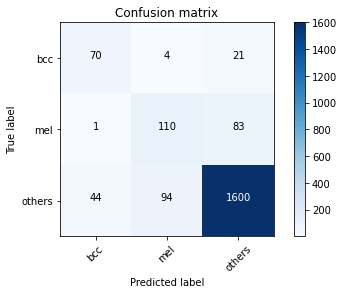

In [20]:
%matplotlib inline
model_trainer.plot_confusion_matrix()

### Adding extra layers - normalised (4 dense and dropout)

In [8]:
name = 'ham_10000_resnet50_4D&D'
model_config3 = yaml.safe_load(yaml_config3)
model_trainer = ModelTrainer.load_from_config(model_config3[name], '/home/ubuntu/data/3classes', 
                                              retrain = True)

model_trainer.class_weight = {0:2.0,1:2.0,2:1.0}

model3 = ham_10000_resnet50()
model_trainer.register_model(model3)

attention model
Found 25500 images belonging to 3 classes.
Found 2027 images belonging to 3 classes.
New model created


In [9]:
model_trainer.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [10]:
model_trainer.train(epochs=40, verbose = 1)

Epoch 1/40
797/797 [==============================] - 299s 361ms/step - loss: 4.6750 - accuracy: 0.5660 - val_loss: 2.2728 - val_accuracy: 0.6912

Epoch 00001: val_loss improved from inf to 2.27275, saving model to /home/alol_elba/download/anaconda3/Capstone/dataset/models/HAM_10000_ResNet50/weights.h5
Epoch 2/40
797/797 [==============================] - 250s 314ms/step - loss: 3.2450 - accuracy: 0.7773 - val_loss: 2.1239 - val_accuracy: 0.7193

Epoch 00002: val_loss improved from 2.27275 to 2.12392, saving model to /home/alol_elba/download/anaconda3/Capstone/dataset/models/HAM_10000_ResNet50/weights.h5
Epoch 3/40
797/797 [==============================] - 250s 314ms/step - loss: 2.8912 - accuracy: 0.8160 - val_loss: 1.9450 - val_accuracy: 0.7617

Epoch 00003: val_loss improved from 2.12392 to 1.94500, saving model to /home/alol_elba/download/anaconda3/Capstone/dataset/models/HAM_10000_ResNet50/weights.h5
Epoch 4/40
797/797 [==============================] - 250s 314ms/step - loss: 2.

In [11]:
%matplotlib inline
model_trainer.plot_confusion_matrix()

              precision    recall  f1-score   support

         bcc       0.52      0.79      0.62        95
         mel       0.45      0.58      0.51       194
      others       0.94      0.88      0.91      1738

    accuracy                           0.85      2027
   macro avg       0.64      0.75      0.68      2027
weighted avg       0.88      0.85      0.86      2027



# NEW AWS CREATED Adding extra layers - normalised (3 dense and dropout) 600,450 res

In [9]:
name = 'ham_10000_resnet50_3D&D600450'
model_config3 = yaml.safe_load(yaml_config3)
model_trainer = ModelTrainer.load_from_config(model_config3[name], '/home/ubuntu/data/3classes', 
                                              retrain = True)

model_trainer.class_weight = {0:2.0,1:2.0,2:1.0}

model3 = ham_10000_resnet50()
model_trainer.register_model(model3)

attention model
Found 25500 images belonging to 3 classes.
Found 2051 images belonging to 3 classes.
New model created


In [10]:
model_trainer.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 600, 450, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 606, 456, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 300, 225, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 300, 225, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [11]:
model_trainer.train(epochs=33, verbose = 1)

Epoch 1/33
797/797 [==============================] - 467s 577ms/step - loss: 2.4372 - accuracy: 0.6587 - val_loss: 1.5055 - val_accuracy: 0.7206

Epoch 00001: val_loss improved from inf to 1.50545, saving model to /home/ubuntu/data/3classes/models//ham_10000_resnet50_3D&D600450/weights.h5
Epoch 2/33
797/797 [==============================] - 459s 575ms/step - loss: 1.5741 - accuracy: 0.8294 - val_loss: 1.2058 - val_accuracy: 0.8147

Epoch 00002: val_loss improved from 1.50545 to 1.20585, saving model to /home/ubuntu/data/3classes/models//ham_10000_resnet50_3D&D600450/weights.h5
Epoch 3/33
797/797 [==============================] - 457s 573ms/step - loss: 1.3022 - accuracy: 0.8617 - val_loss: 1.0716 - val_accuracy: 0.8279

Epoch 00003: val_loss improved from 1.20585 to 1.07156, saving model to /home/ubuntu/data/3classes/models//ham_10000_resnet50_3D&D600450/weights.h5
Epoch 4/33
797/797 [==============================] - 459s 575ms/step - loss: 1.1105 - accuracy: 0.8823 - val_loss: 0.9

              precision    recall  f1-score   support

         bcc       0.64      0.66      0.65        95
         mel       0.64      0.62      0.63       239
      others       0.93      0.93      0.93      1717

    accuracy                           0.88      2051
   macro avg       0.74      0.74      0.74      2051
weighted avg       0.88      0.88      0.88      2051



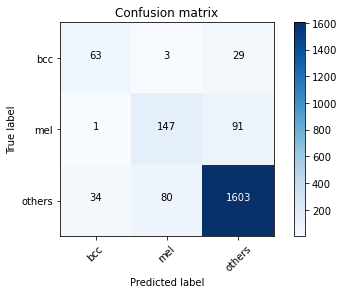

In [12]:
%matplotlib inline
model_trainer.plot_confusion_matrix()

# NEW AWS CREATED 2 Adding extra layers - normalised (3 d&d), 512 res

In [16]:
name = 'ham_10k_resnet50_512'
model_config3 = yaml.safe_load(yaml_config3)
model_trainer = ModelTrainer.load_from_config(model_config3[name], '/home/ubuntu/data/3classes', retrain = True)

model_trainer.class_weight = {0:2.0,1:2.0,2:1.0}

model3 = ham_10000_resnet50()
model_trainer.register_model(model3)

attention model
Found 25500 images belonging to 3 classes.
Found 2051 images belonging to 3 classes.
New model created


In [17]:
model_trainer.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [18]:
model_trainer.train(epochs=33, verbose = 1)

Epoch 1/50
797/797 [==============================] - 428s 530ms/step - loss: 2.4782 - accuracy: 0.6563 - val_loss: 1.4830 - val_accuracy: 0.7669

Epoch 00001: val_loss improved from inf to 1.48302, saving model to /home/ubuntu/data/3classes/models//HAM_10k_ResNet50_512/weights.h5
Epoch 2/50
797/797 [==============================] - 419s 525ms/step - loss: 1.6139 - accuracy: 0.8289 - val_loss: 1.2595 - val_accuracy: 0.8157

Epoch 00002: val_loss improved from 1.48302 to 1.25950, saving model to /home/ubuntu/data/3classes/models//HAM_10k_ResNet50_512/weights.h5
Epoch 3/50
797/797 [==============================] - 419s 525ms/step - loss: 1.3420 - accuracy: 0.8601 - val_loss: 1.0586 - val_accuracy: 0.8674

Epoch 00003: val_loss improved from 1.25950 to 1.05858, saving model to /home/ubuntu/data/3classes/models//HAM_10k_ResNet50_512/weights.h5
Epoch 4/50
797/797 [==============================] - 421s 528ms/step - loss: 1.1459 - accuracy: 0.8826 - val_loss: 0.9883 - val_accuracy: 0.8498


KeyboardInterrupt: 

              precision    recall  f1-score   support

         bcc       0.75      0.56      0.64        95
         mel       0.69      0.51      0.58       239
      others       0.91      0.96      0.94      1717

    accuracy                           0.89      2051
   macro avg       0.78      0.67      0.72      2051
weighted avg       0.88      0.89      0.88      2051



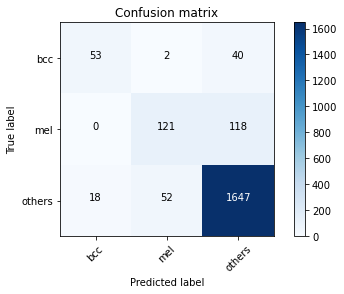

In [19]:
#original training CM
%matplotlib inline
model_trainer.plot_confusion_matrix()